# Navigation

---

Train an agent to collect tasty yellow bananas! Oh no, not the blue ones!

<table>
  <tr>
    <td><img src="files/images/banana_collector_firstview.gif" align="center"></td>
    <td><img src="files/images/banana_collector_topview.gif" align="center"></td>
  </tr>
</table>

---

## 0. Import Modules & Packages

Get all the necessary modules to run this notebook!

In [1]:
# DO NOT CHANGE THE LINES IN THIS CELL
import os.path as osp
from collections import deque
from time import sleep
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn.functional as F

from dqn_agent import Agent

STATE_SIZE  = 37
ACTION_SIZE = 4
BRAIN_NAME  = "BananaBrain"

---

## 1. Explore the Environment

Let's take a look at what this environment looks like.

Starting from loading the environment!

### 1.1 Finding the Environment File

If you haven't already downloaded the environment file, please do so before we begin.

The links can be found in my README file [here](https://github.com/dragonoken/Udacity-DRL-Nanodegree-Navigation-Project).

Then, the next cell below will automatically find the environment file in the same directory.

If you have downloaded the files somewhere else, or renamed it for some reason, you need to specify the file path to the environment file manually at the bottom of the code cell.

In [2]:
env_file_path = "Banana_Windows_x86_64/Banana.exe"

### 1.2 Watch the Environment with Random Actions

The next code cell will start the environment and show you how it looks when taking random actions.

In [ ]:
env = UnityEnvironment(file_name=env_file_path)
env_info = env.reset(train_mode=False)[BRAIN_NAME] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
t = 0
while True:
    action = np.random.randint(ACTION_SIZE)        # select an action
    env_info = env.step(action)[BRAIN_NAME]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    t += 1
    print("\rCurrent score at {}: {}".format(t, score), end='')
    if done:                                       # exit loop if episode finished
        break
    
print("\nFinal Score: {}".format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Current score at 59: -1.0

---

## 2. Train Your Own Agent!

You can train your own agent to solve this environment in this section!

### 2.1 Set Hyperparameters and Training Parameters

You will be using my baseline agent algorithm, but you can totally adjust many of its hyperparameters in the cell below!

Try playing with various hyperparameters and training parameters here.

See if you can find a set of parameters that can solve the environment with the least number of episodes!

In [29]:
# Hyperparameters

hyperparams = {
    'seed':                3,       # random seed
    'buffer_size':         100000,  # size of the experience replay buffer
    'batch_size':          8,       # number of experiences to sample at each learning step
    'start_since':         8,       # number of experiences to store before it begins learning (must be bigger than 'batch_size')
    'gamma':               0.99,    # discount factor
    'target_update_every': 1,       # how often to update the target network
    'tau':                 1e-3,    # how much to update the target network at every update
    'lr':                  5e-4,    # learning rate
    'update_every':        1,       # how often to update the online network
    'priority_eps':        1e-3,    # small values added to priorities in order to have nonzero priorities
    'a':                   0.5,     # priority exponent parameter
    'n_multisteps':        3,       # number of steps to consider for multistep learning
    'v_min':               -10,     # minimum support value for distributional learning
    'v_max':               10,      # maximum support value for distributional learning
    'n_atoms':             51,      # number of supports for distributional learning
    'initial_sigma':       0.05,    # initial noise parameter value for noisy net
    'linear_type':         'noisy', # which linear layers to use ('linear' or 'noisy'; 'linear' to disable noisy net)
    'factorized':          False    # whether to use factorized gaussian noise or not
}

# Training Parameters

train_params = {
    'n_episodes': 100,                                    # number of episodes to train the agent for
    'eps_start':  0.,   'eps_end':  0.,  'eps_decay': 0., # initial, minimum epsilon values and decay rate for epsilon-greedy policy
    'beta_start': 0.4,   'beta_end': 1.0                  # importance-sampling weight for prioritized experience replay
}

temporal_memory_length = 10

### 2.2 Initialize the Agent

The next code cell below will now initialize an agent using the hyperparameter settings above!

In [4]:
agent = Agent(state_size=STATE_SIZE * temporal_memory_length, action_size=ACTION_SIZE, **hyperparams)

agent.qnetwork_local

QNetwork(
  (fc0): Linear(in_features=370, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3_s): NoisyLinear(in_features=256, out_features=128, bias=True, initial_sigma=0.05, factorized=False)
  (fc3_a): NoisyLinear(in_features=256, out_features=128, bias=True, initial_sigma=0.05, factorized=False)
  (fc4_s): NoisyLinear(in_features=128, out_features=51, bias=True, initial_sigma=0.05, factorized=False)
  (fc4_a): NoisyLinear(in_features=128, out_features=204, bias=True, initial_sigma=0.05, factorized=False)
  (hidden_activation): ReLU()
)

### 2.3 Train the Agent

Finally, you can start training your agent in the cell below!

This process will take some time, depending on your computer's performance.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Episode 100 | Total Steps: 30000 | Current Score:  14 | Positive Score:  14 | Negative Score:   0 | Average Score:   3.82 | Epsilon: 0.0000 | A: 0.5000 | Beta: 1.0000 | Avg Noise Magnitude: 0.0460 +- 0.0315          


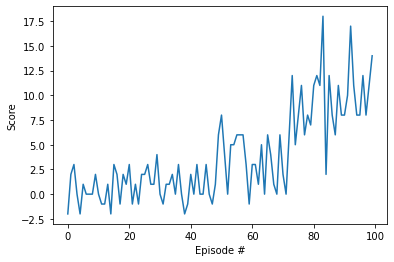

In [5]:
# You may set `no_graphics=True` for speeding up the training process
env = UnityEnvironment(file_name=env_file_path, seed=hyperparams['seed'], no_graphics=True)

def dqn(n_episodes=2000,
        eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        beta_start=0., beta_end=1.0,
        continue_after_solved=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        beta_start (float): initial importance-sampling weight for prioritized experience replay
        beta_end (float): final importance-sampling weight for prioritized experience replay
        continue_after_solved (bool): whether to continue training after reaching the average score 12
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    agent.beta = beta_start
    beta_increment = (beta_end - beta_start) / n_episodes
    
    noisy_params = [param for name, param in agent.qnetwork_local.named_parameters() if name.endswith('noisy_weight') or name.endswith('noisy_bias')]
        
    solved = False
    epi_str_max_len = len(str(n_episodes))
    total_steps_str_max_len = len(str(n_episodes * 300))
    n_steps_taken = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[BRAIN_NAME]
        temporal_memory = deque([np.zeros(STATE_SIZE) for _ in range(temporal_memory_length - 1)]
                                + [env_info.vector_observations[0]], maxlen=temporal_memory_length)
#         state = env_info.vector_observations[0]
        state = np.concatenate(temporal_memory)
        pos_score = 0
        neg_score = 0
        t = 0
        while True:
            action     = int(agent.act(state, eps))
            env_info   = env.step(action)[BRAIN_NAME]
            temporal_memory.append(env_info.vector_observations[0])
#             next_state = env_info.vector_observations[0]
            next_state = np.concatenate(temporal_memory)
            reward     = env_info.rewards[0]
            done       = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if reward > 0:
                pos_score += reward
            elif reward < 0:
                neg_score += reward
            t += 1
            if done:
                break
        else: # if not done (reached max_t)
            agent.memory.reset_multisteps()
        n_steps_taken += t
        score = pos_score + neg_score
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        agent.beta = min(beta_end, agent.beta + beta_increment)
        report_str = "\rEpisode {:>{epi_max_len}d} | Total Steps: {:>{total_steps_max_len}d} | Current Score: {:>3.0f}"\
                     " | Positive Score: {:>3.0f} | Negative Score: {:>3.0f} | Average Score: {:>6.2f} | Epsilon: {:>6.4f}"\
                     " | A: {:>6.4f} | Beta: {:>6.4f}"\
                     .format(i_episode, n_steps_taken, score, pos_score, neg_score, np.mean(scores_window),
                             eps, agent.a, agent.beta, epi_max_len=epi_str_max_len,
                             total_steps_max_len=total_steps_str_max_len)
        if noisy_params:
            flattened_abs_noise = np.concatenate([param.data.abs().cpu().numpy().reshape((-1,)) for param in noisy_params])
            report_str += " | Avg Noise Magnitude: {:>6.4f} +- {:<6.4f}".format(np.mean(flattened_abs_noise), np.std(flattened_abs_noise))
        report_str += "          "
        if i_episode % 100 == 0:
            report_str += '\n'
        print(report_str, end="")
        if not solved and np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            solved = True
            if not continue_after_solved:
                break
    return scores

scores = dqn(**train_params,
             continue_after_solved=True)

env.close()

# plot the scores
plt.rcParams['figure.facecolor'] = 'w'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 2.4 Save the Trained Agent

Don't forget to save your trained agent!

Save your agents parameters, hyperparameters, and training parameters along with the scores it received during the training!

In [6]:
torch.save({'model_dict': agent.qnetwork_local.state_dict(),
            'scores': scores,
            'hyperparams': hyperparams,
            'train_params': train_params}, 'my_agent.pth')

---

## 3. Watch the Smart Agent

Now it's time to watch the smart agent—my pretrained one or your own—collecting delicious bananas!

### 3.1 Loading the Saved Agent Model

You first need to load the saved model.

In [15]:
def load_model(filepath):
    loaded_dict = torch.load(filepath, map_location=torch.device('cpu'))
    agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, **loaded_dict['hyperparams'])
    agent.qnetwork_local.load_state_dict(loaded_dict['model_dict'])
    agent.qnetwork_target.load_state_dict(loaded_dict['model_dict'])
    return agent

Edit the file path in the cell below according to the location of the save file you want to load.

In [19]:
agent = load_model("./pretrained.pth")

### 3.2 Watch the Smart Agent

Now, the next cell will show you the loaded agent in action in real time!

In [26]:
env = UnityEnvironment(file_name=env_file_path, no_graphics=True)

env_info = env.reset(train_mode=False)[BRAIN_NAME] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
t = 0                                              # initialize the time step count
while True:
    action = int(agent.act(state))                 # select an action
    env_info = env.step(action)[BRAIN_NAME]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    t += 1
    print("\rCurrent score at {}: {}".format(t, score), end='')
    sleep(0.025)
    if done:                                       # exit loop if episode finished
        break

print("\nFinal Score: {}".format(score))
env.close()

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


### 3.3 Performance Estimation

Usually it's better to run many episodes to get a much accurate estimate of an agent's performance.

The code cell below will run the agent at a fast-forward speed and show you the average performance over multiple episodes!

In [23]:
env = UnityEnvironment(file_name=env_file_path, no_graphics=False)

n_episodes = 100    # total number of episodes to run
total_score = 0     # initialize the cumulative score
last_score = 0      # initualize the previous score
report_str_format = "\rEpisode {{{}}} | Current Score {{:>4.1f}} | Last Score {{:>4.1f}} | Average Score {{:>5.2f}}".format(":>{}d".format(len(str(n_episodes))))
for n in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[BRAIN_NAME]  # reset the environment
    temporal_memory = deque([np.zeros(STATE_SIZE) for _ in range(temporal_memory_length - 1)]
                             + [env_info.vector_observations[0]], maxlen=temporal_memory_length)
#     state = env_info.vector_observations[0]            # get the current state
    state = np.concatenate(temporal_memory)
    score = 0                                          # initialize the score
    while True:
        action = int(agent.act(state))                 # select an action
        env_info = env.step(action)[BRAIN_NAME]        # send the action to the environment
        temporal_memory.append(env_info.vector_observations[0])
#         next_state = env_info.vector_observations[0]   # get the next state
        next_state = np.concatenate(temporal_memory)
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        print(report_str_format.format(n, score, last_score, total_score / n), end='')
        if done:                                       # exit loop if episode finished
            break
    last_score = score
    total_score += score
env.close()

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\ohara\AppData\Local\conda\conda\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


---

# Thank you!

I hope you had fun here!

Happy Deep Reinforcement Learning!